In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
import ast
%config InlineBackend.figure_format = 'retina' 
from scipy.spatial import cKDTree
from geopy.distance import geodesic
import warnings
warnings.filterwarnings('ignore')
from src import utils_HydroWaste as utils

In [2]:
orange_color = "#ea801c"
blue_color = "#1a80bb"
green_color = "#6abf69"
state_name_abbrev_pair = utils.state_name_abbrev_pair()

## Read Data

In [3]:
df_hw_us = utils.read_HydroWaste_data(
    HydroWaste_path="../HydroWASTE_v10/HydroWASTE_v10.csv",
    us_boundary_path="../HydroWASTE_v10/US_State_Boundaries",
)
df_hw_us.head()

,hw_WWTP_NAME,hw_lat,hw_lon,state,geometry
0,AKRON LAGOON,32.886,-87.740,Alabama,POINT (-87.74000 32.88600)
1,ALABASTER WWTP,33.253,-86.815,Alabama,POINT (-86.81500 33.25300)
2,ALEXANDER CITY SUGAR CREEK WWTP,32.901,-85.951,Alabama,POINT (-85.95100 32.90100)
3,ALEXANDER CITY COLEY CREEK WWTP,32.930,-85.882,Alabama,POINT (-85.88200 32.93000)
4,ALTOONA LAGOON,34.038,-86.332,Alabama,POINT (-86.33200 34.03800)


In [4]:
df_epa = utils.read_EPA_data(EPA_path="../FRS_Wastewater/CWA_summaries_060314.gdb")
df_epa.head()

,CWP_NAME,CWP_STATE,geometry,epa_lon,epa_lat
0,CURRYVILLE WWTF,MO,POINT (-91.34867 39.35314),-91.348667,39.353139
1,CITY OF EUSTACE WWTP,TX,POINT (-96.00022 32.30208),-96.000222,32.302083
2,FRANKFORT WWTP,KY,POINT (-84.87500 38.21806),-84.875000,38.218056
3,WHITE BLUFF WWTP,TX,POINT (-97.39850 32.02789),-97.398500,32.027889
4,PARKLAND ESTATES WWTP,TX,POINT (-95.29881 29.92550),-95.298806,29.925500


## World Map Plot

In [5]:
us_boundary = gpd.read_file("../HydroWASTE_v10/US_State_Boundaries")

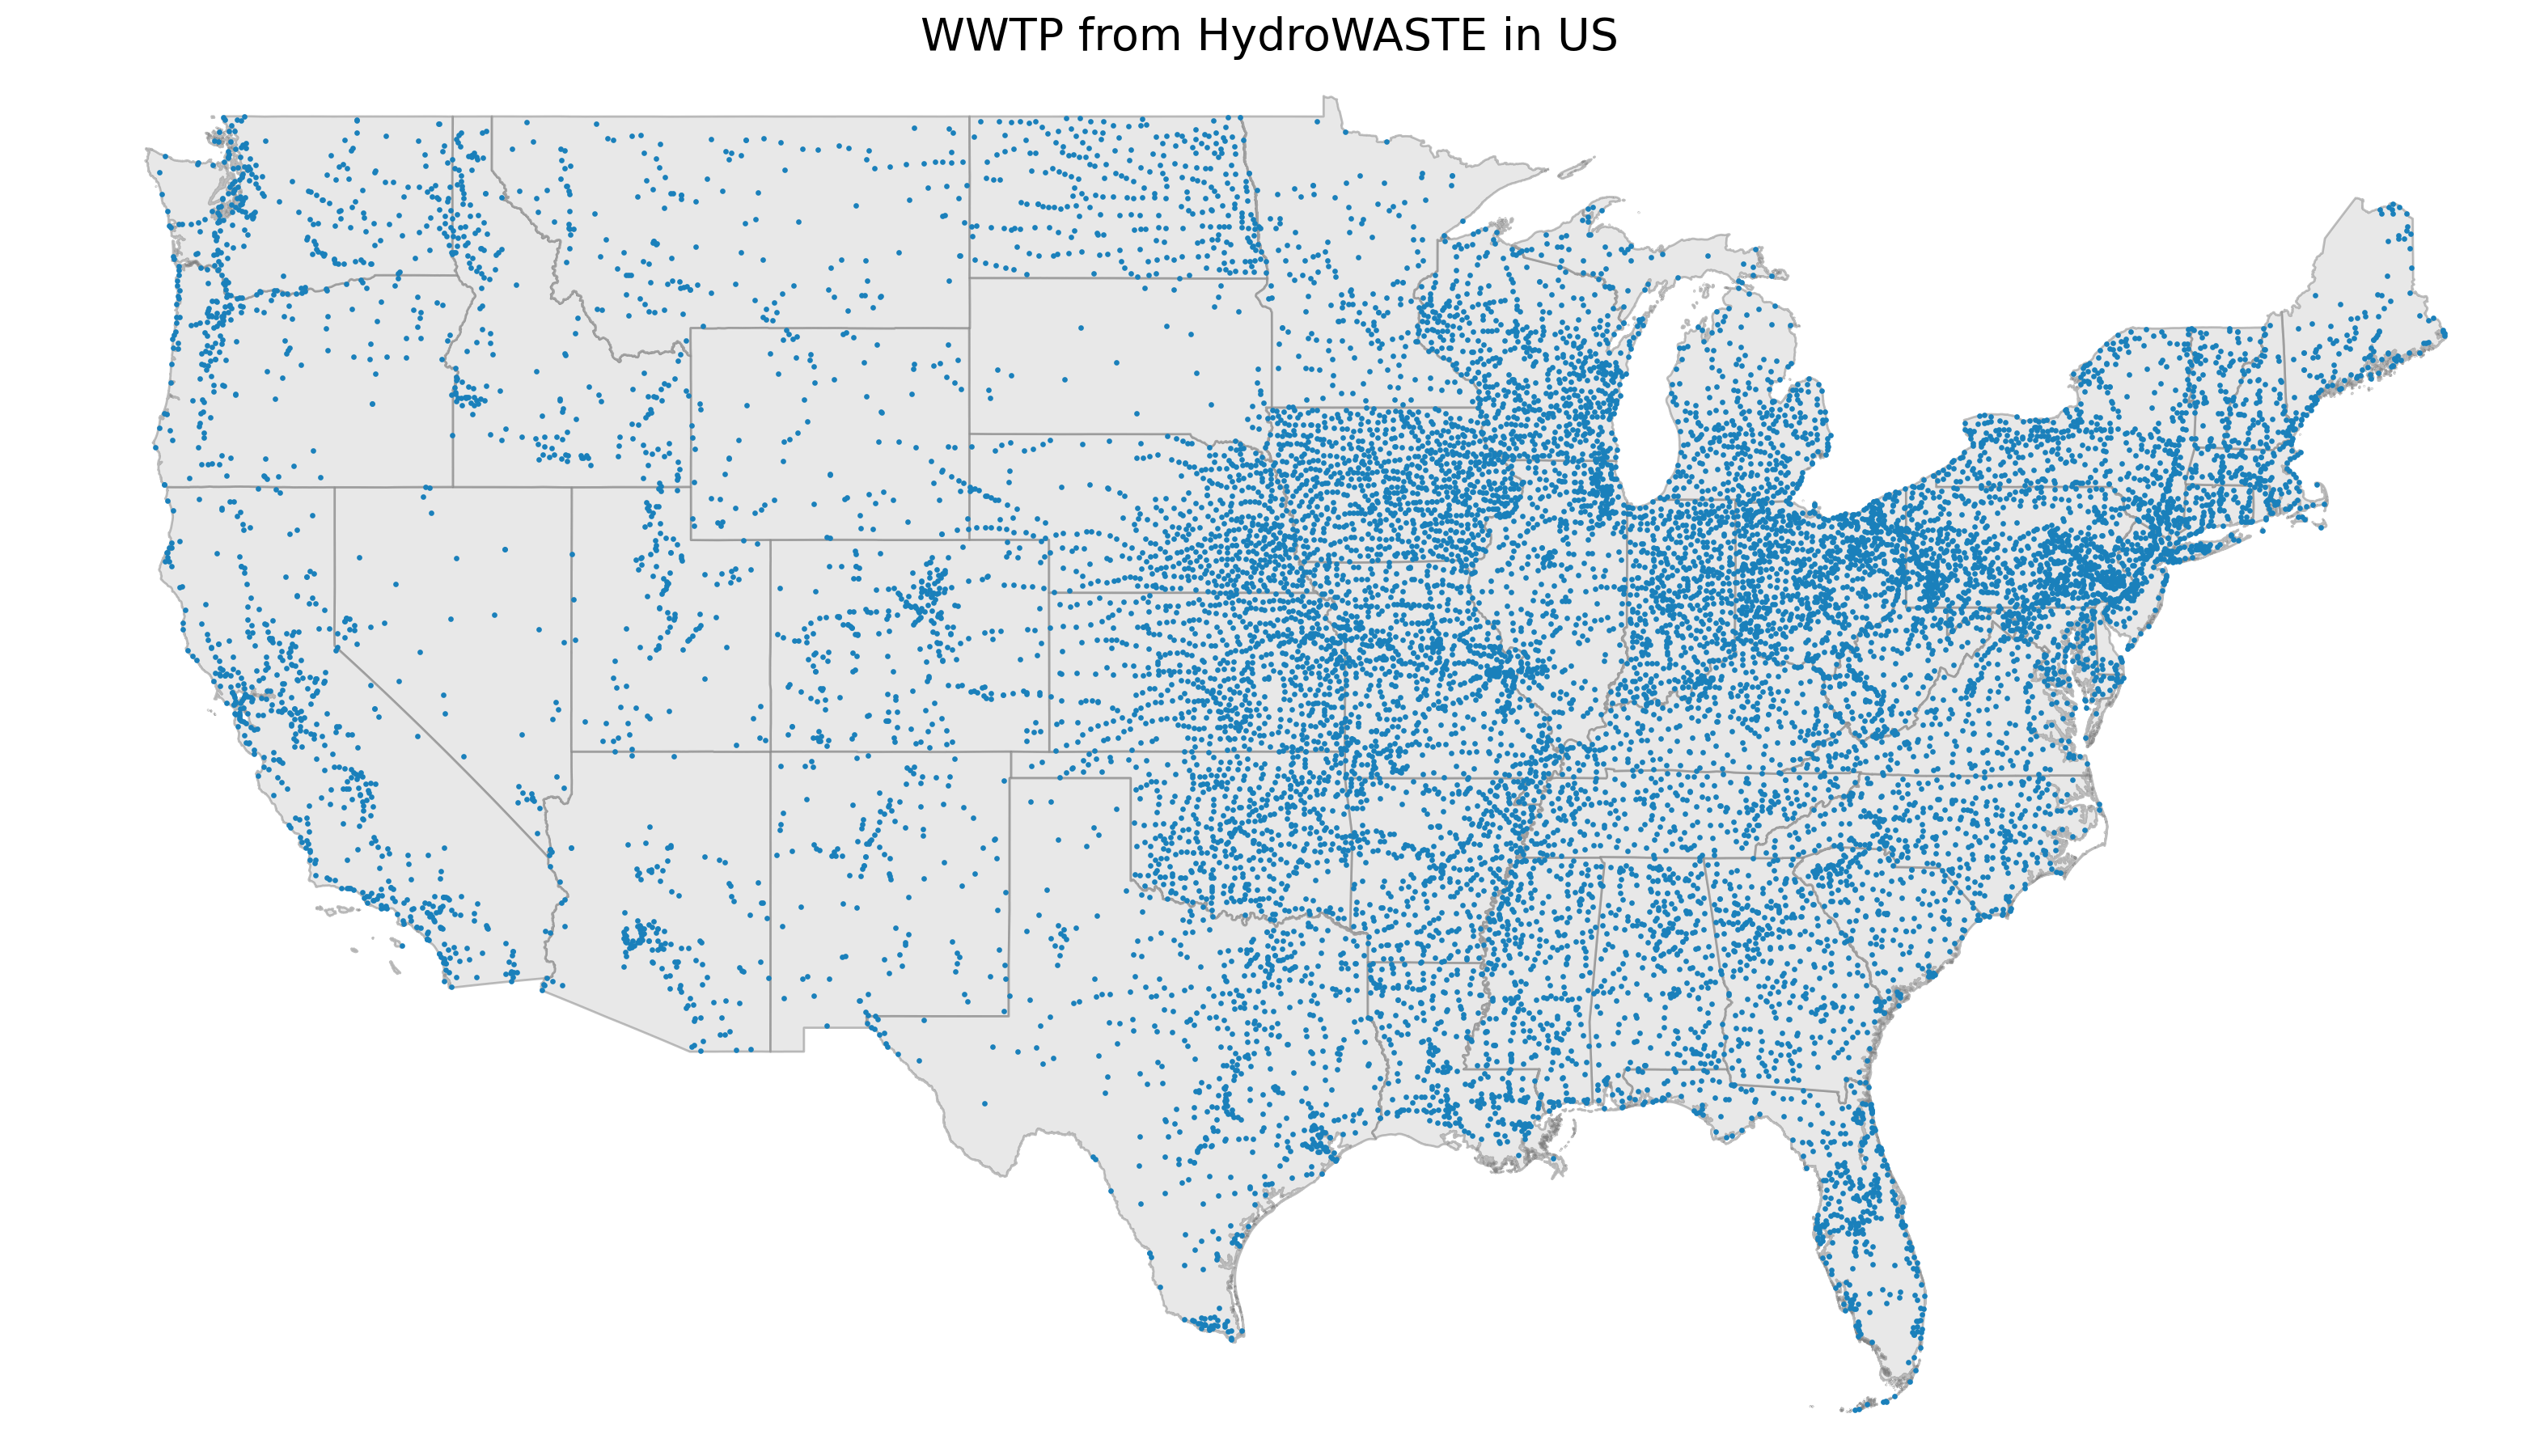

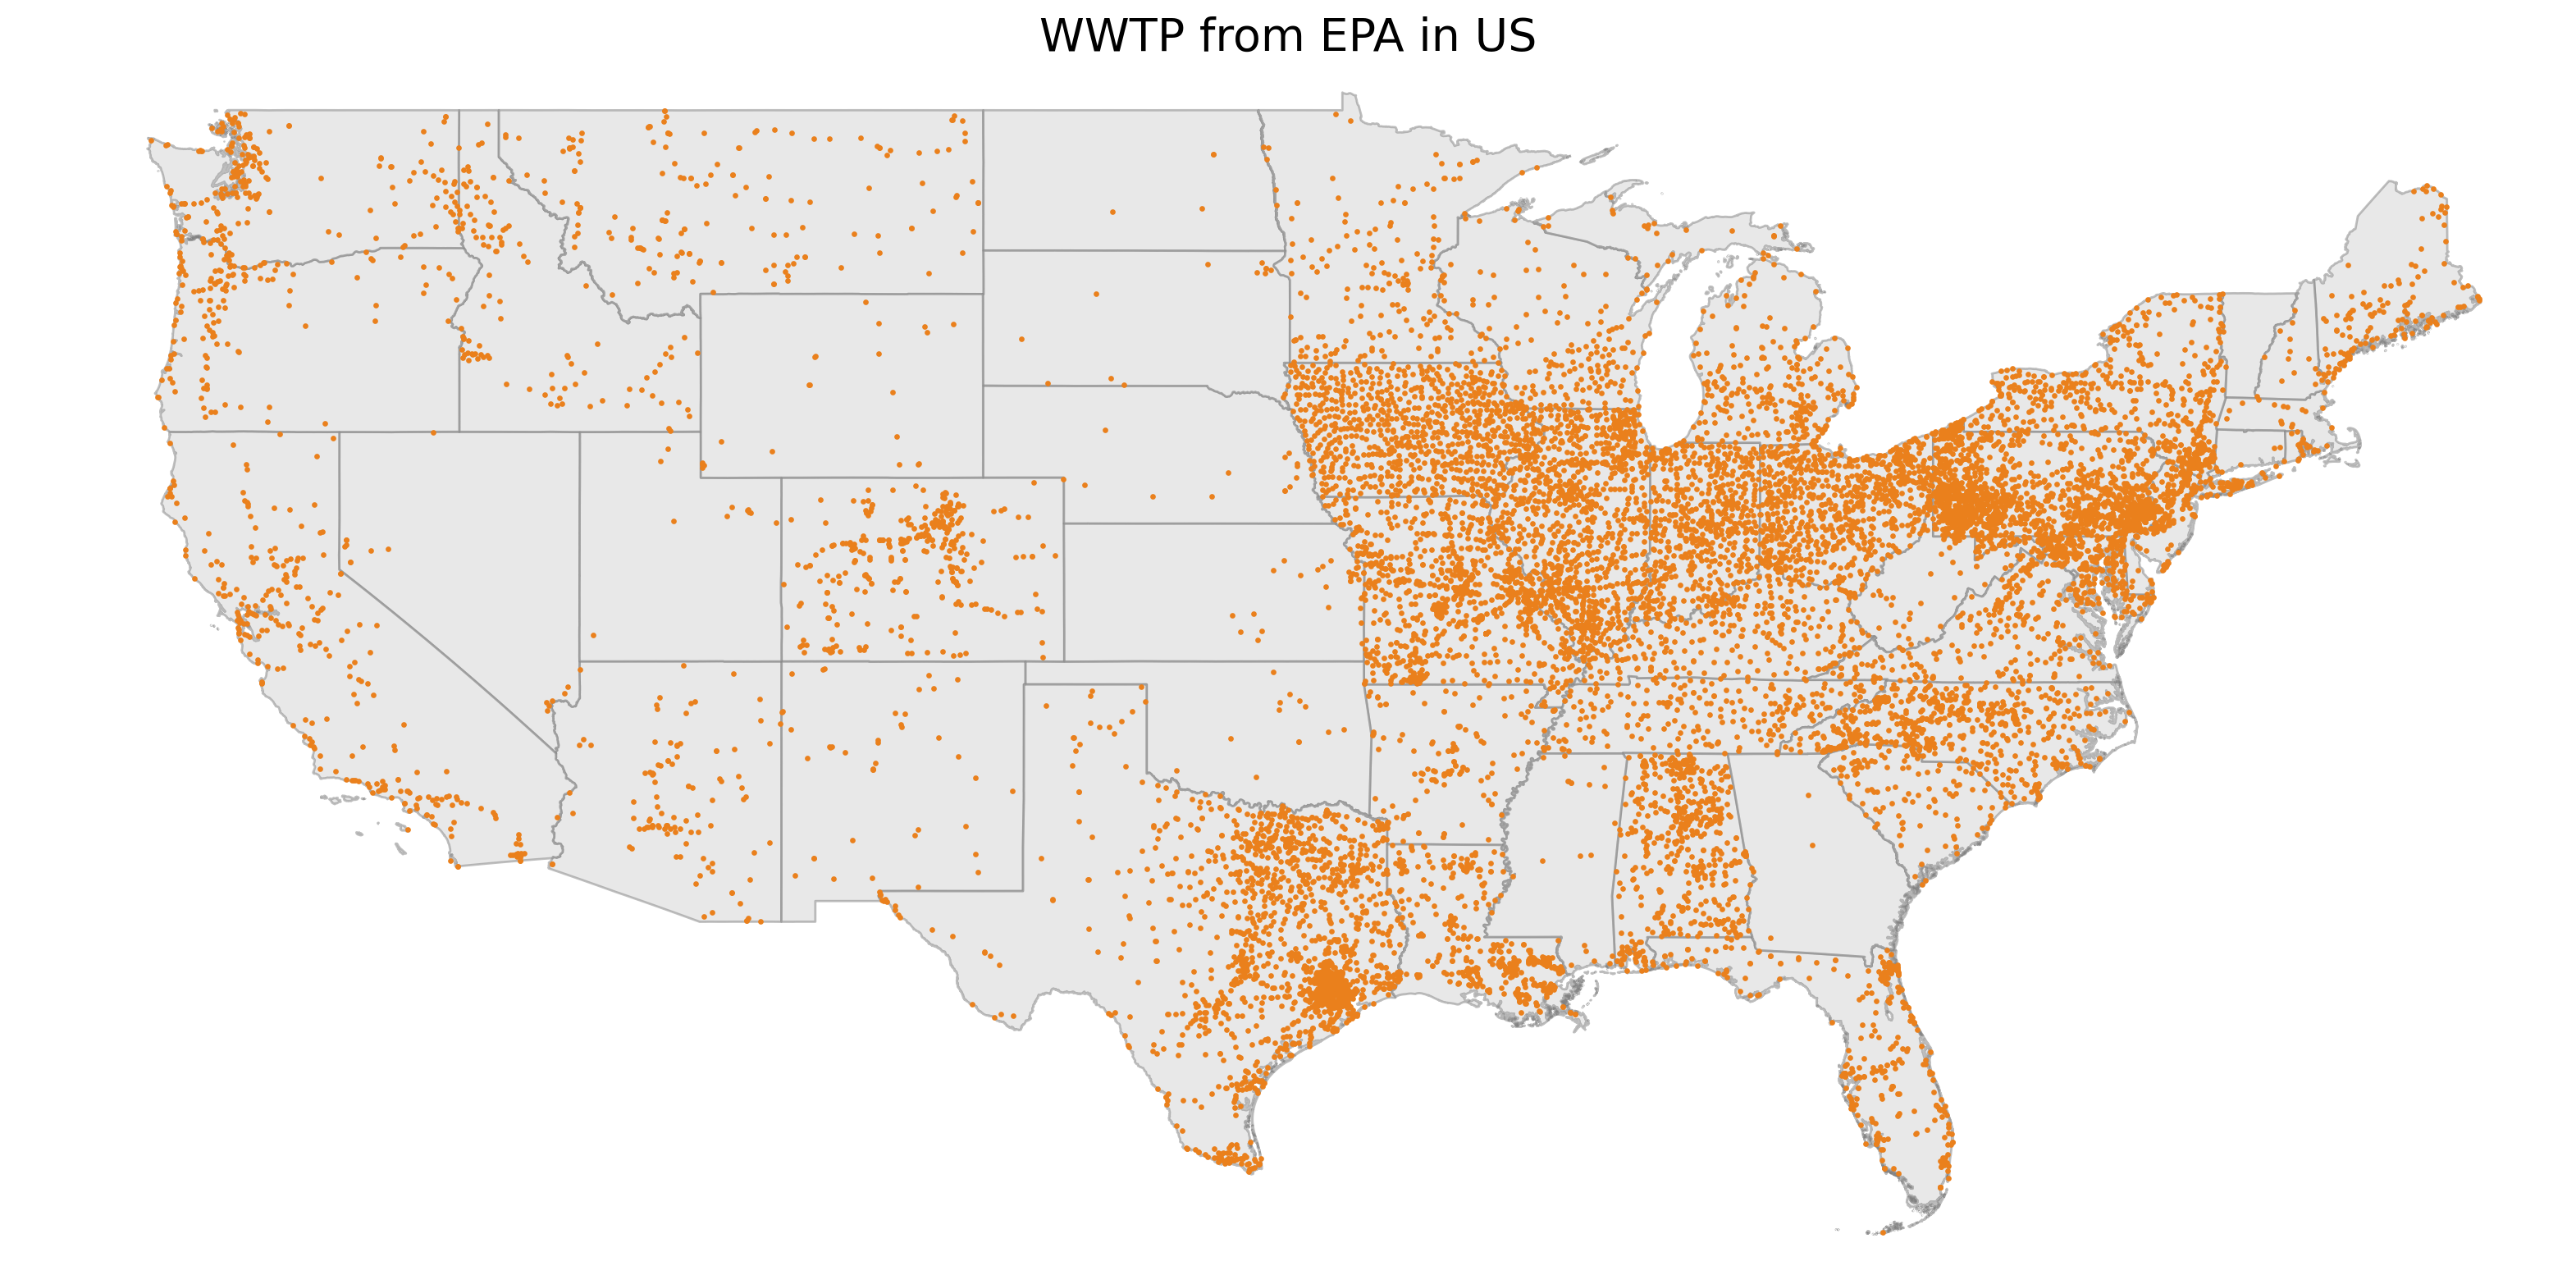

In [6]:
utils.plt_world_map(
    df_hw_us, us_boundary, title="WWTP from HydroWASTE in US", color=blue_color
)
utils.plt_world_map(
    df_epa, us_boundary, title="WWTP from EPA in US", color=orange_color
)

## Plot State-by-State WWTP number from HydroWaste and EPA

Number of WWTPs in the US from HydroWASTE:  14748
Number of WWTPs in the US from epa:  14327
Number of state where HydroWASTE has more WWTPs:  34
State where HydroWASTE has more WWTPs:  ['AZ' 'AR' 'CA' 'CT' 'DE' 'FL' 'GA' 'ID' 'KS' 'KY' 'ME' 'MA' 'MI' 'MN'
 'MS' 'NE' 'NV' 'NH' 'NM' 'NY' 'ND' 'OH' 'OK' 'OR' 'RI' 'SC' 'SD' 'TN'
 'UT' 'VT' 'WA' 'WV' 'WI' 'WY']


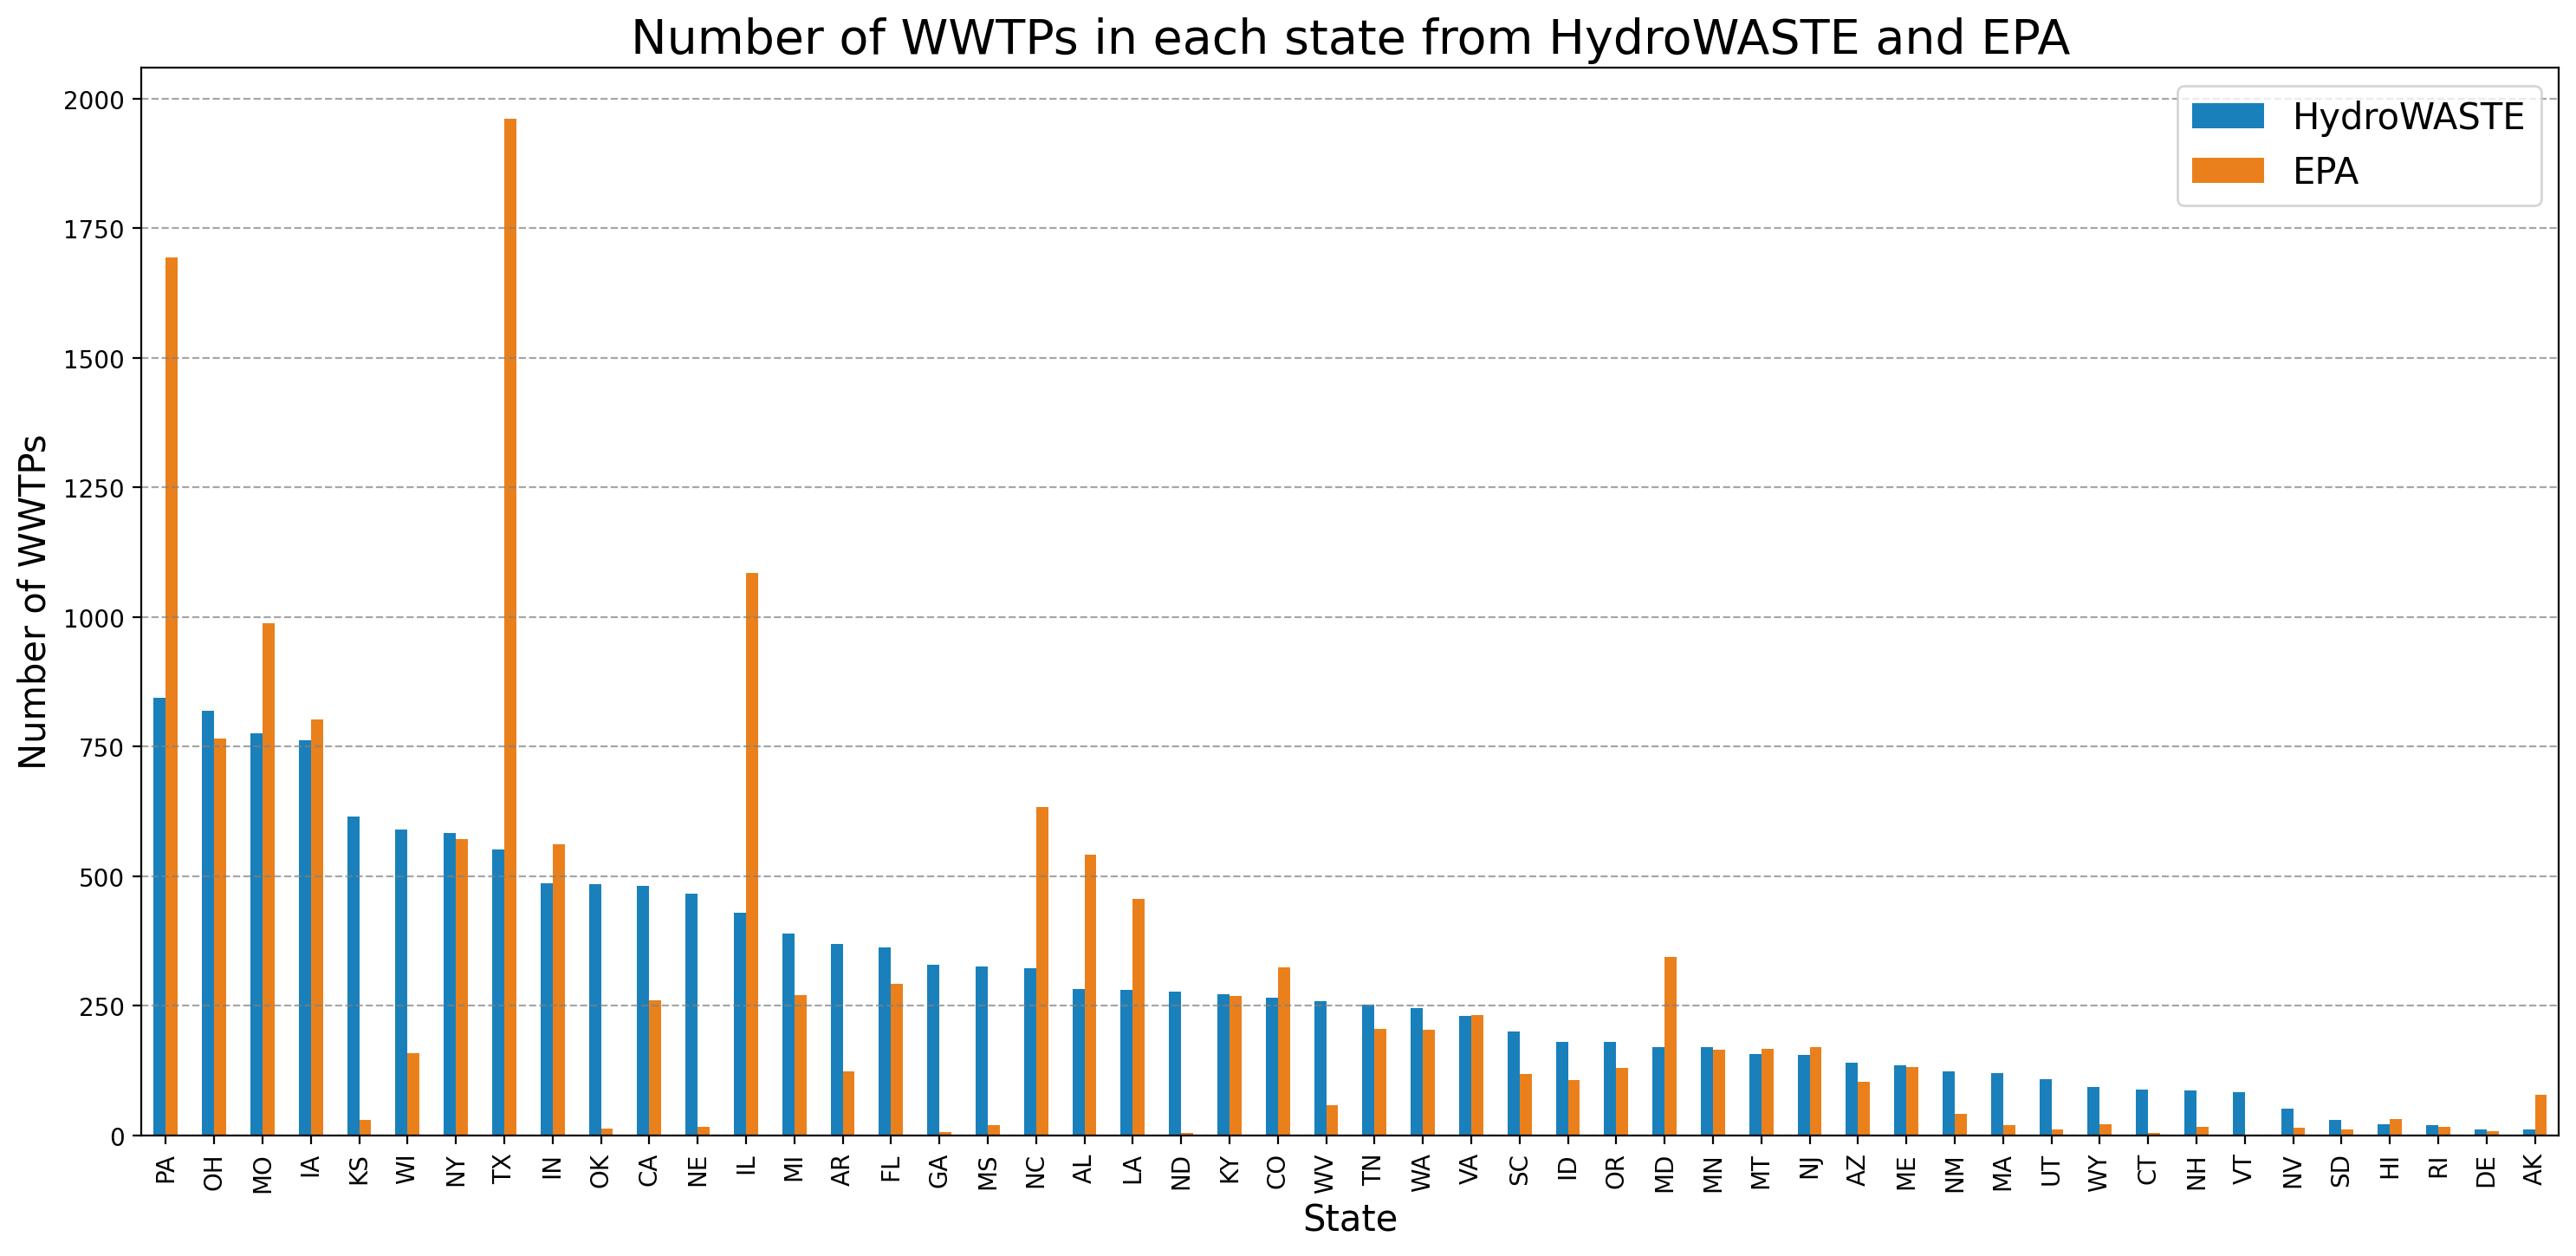

In [7]:
WWTP_num = utils.statewise_WWTP_count(
    hw_df=df_hw_us,
    target_df=df_epa,
    target_df_name="epa",
    state_name_abbrev_pair=state_name_abbrev_pair,
    hw_color=blue_color,
    target_color=orange_color,
)

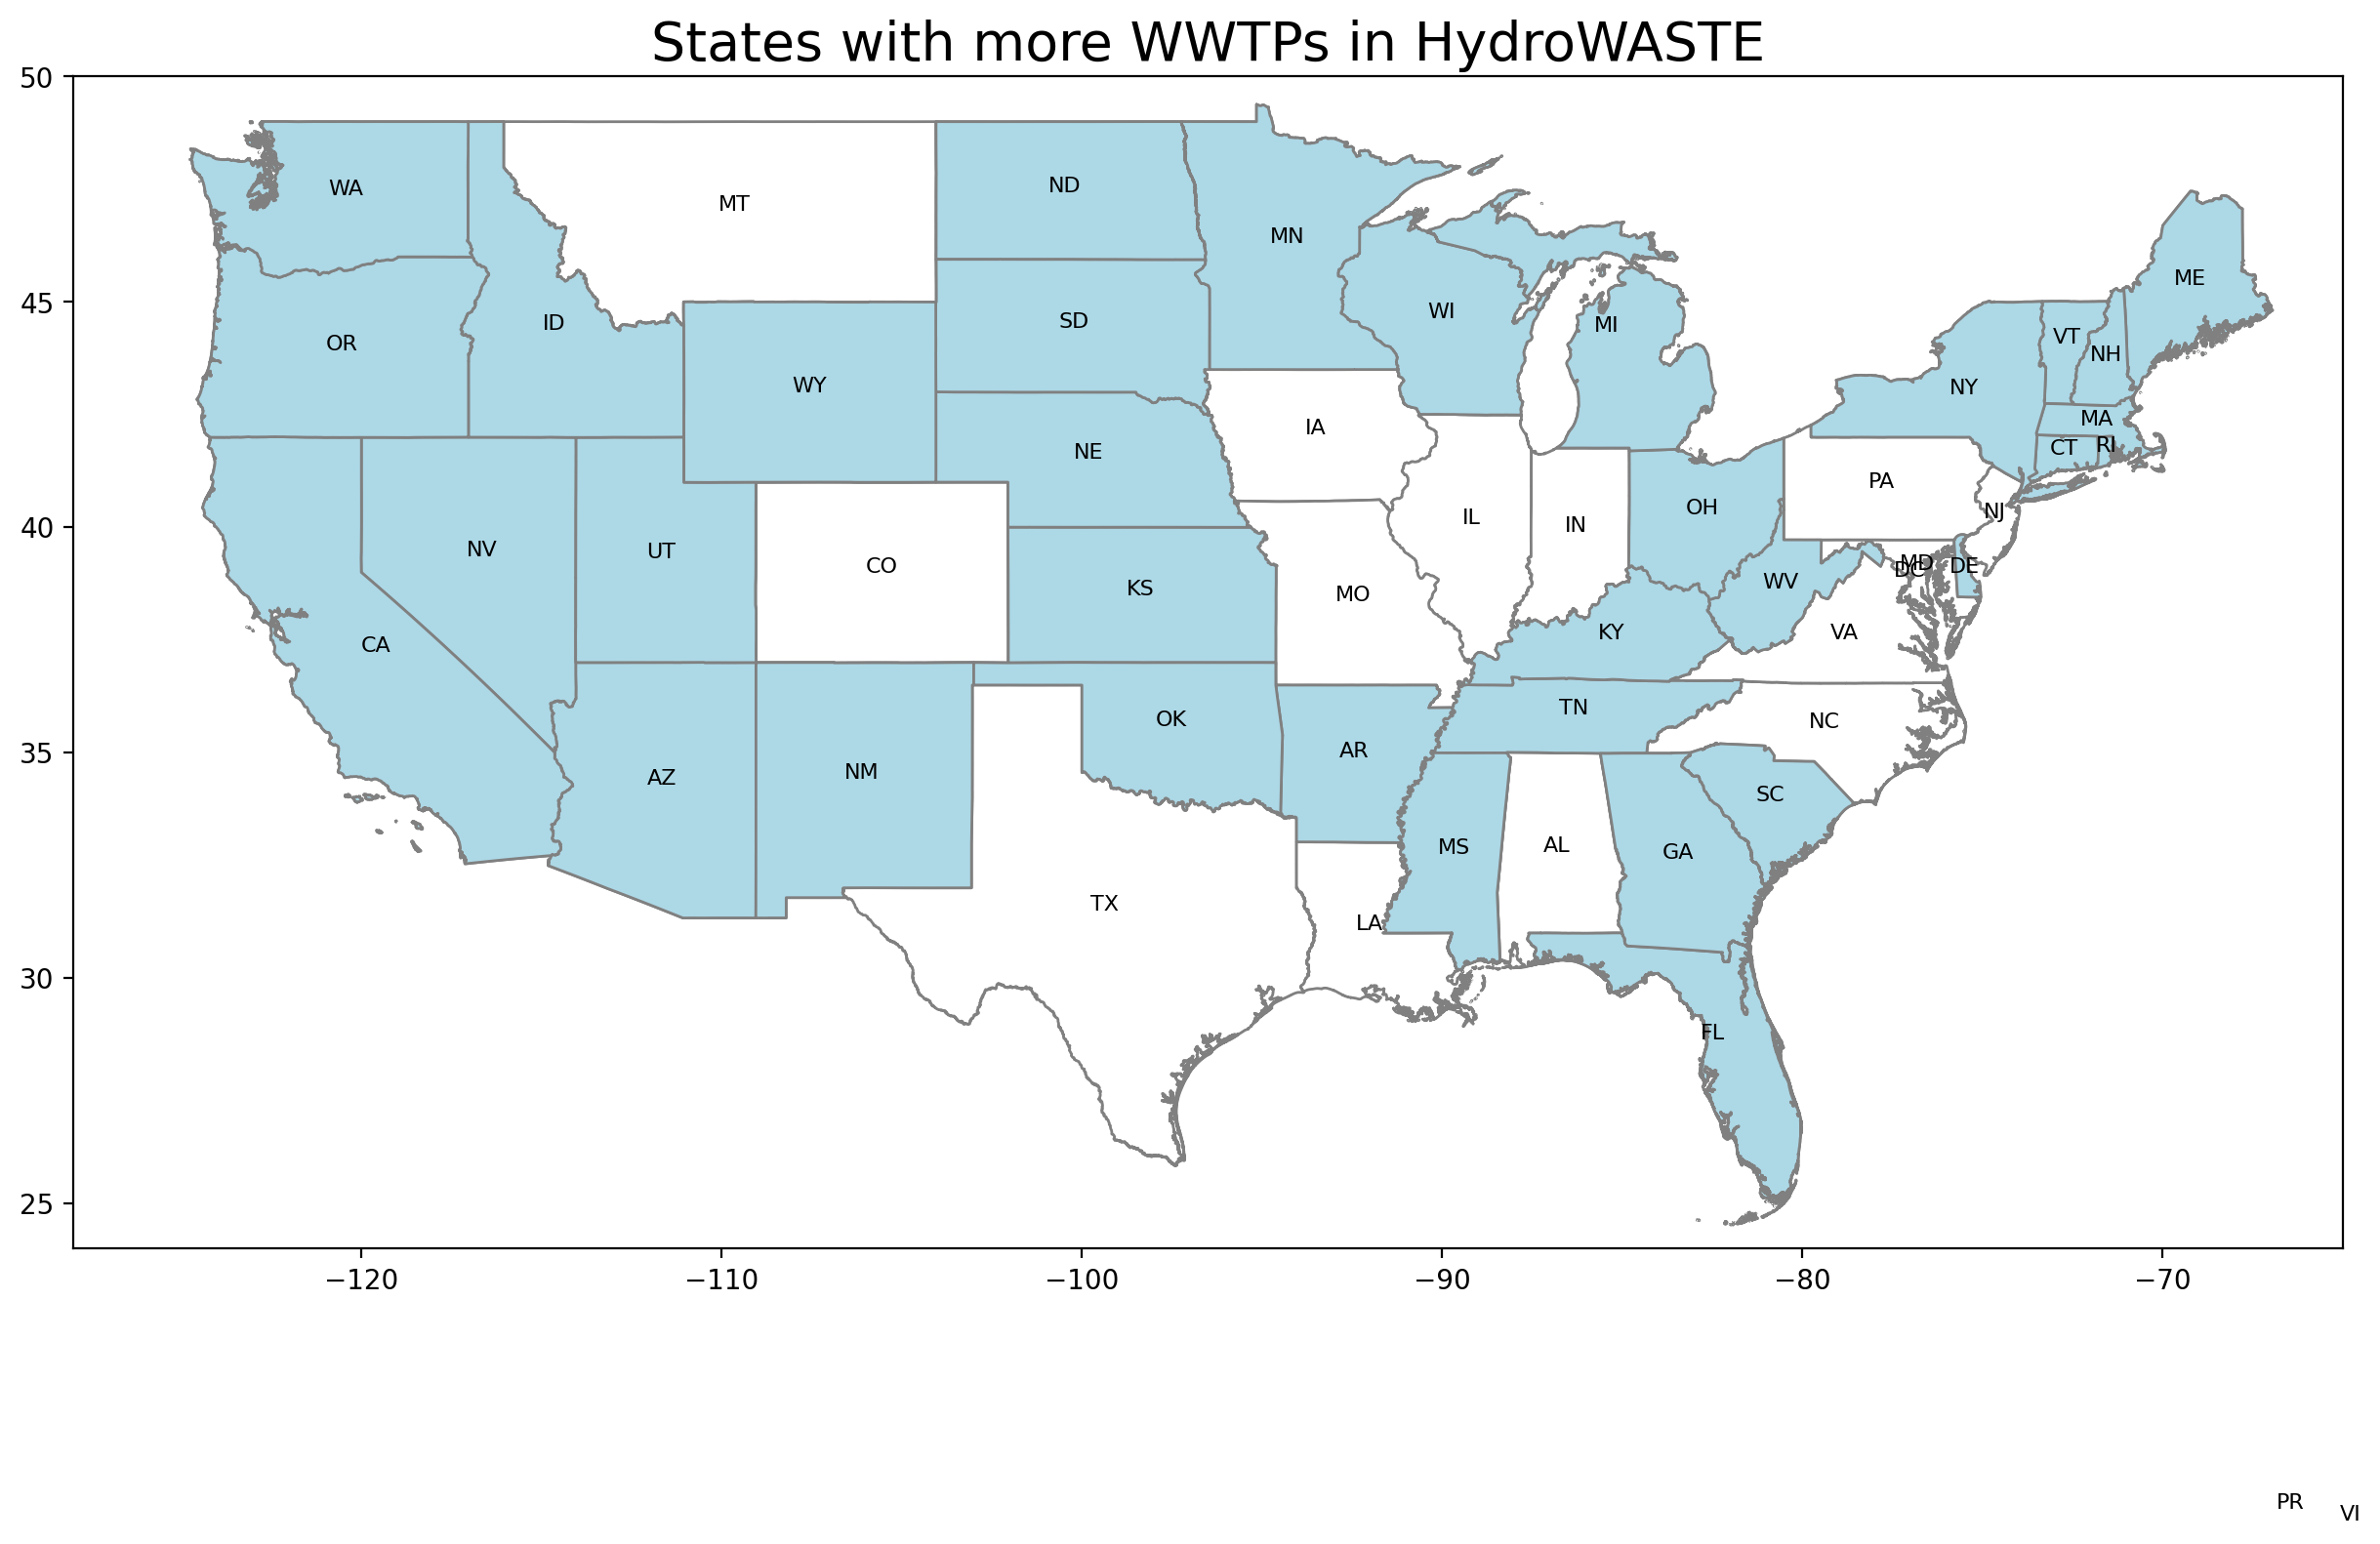

In [9]:
# Highlight the states where HydroWASTE has more WWTPs
selected_states = WWTP_num[WWTP_num["hw_num"] > WWTP_num["epa_num"]]["state"].values
us_boundary_plt = us_boundary.loc[
    (us_boundary["STATE_ABBR"] != "AK") & (us_boundary["STATE_ABBR"] != "HI")
]
us_boundary_plt["highlight"] = us_boundary_plt["STATE_ABBR"].apply(
    lambda x: x in selected_states
)
us_boundary_plt["centroid"] = us_boundary_plt.geometry.centroid

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
base = us_boundary_plt.plot(ax=ax, color="white", edgecolor="grey")
us_boundary_plt[us_boundary_plt["highlight"]].plot(
    ax=base, color="lightblue", edgecolor="grey"
)

# Loop through each state to place the state abbreviation on the map
for idx, row in us_boundary_plt.iterrows():
    plt.text(
        s=row["STATE_ABBR"],
        x=row["centroid"].x,
        y=row["centroid"].y,
        horizontalalignment="center",
        fontsize=8,
    )

ax.set_xlim(-128, -65)
ax.set_ylim(24, 50)
plt.title("States with more WWTPs in HydroWASTE", fontsize=20)
plt.show()

## Find the closest WWTP from EPA to each entry of HydroWaste

In [10]:
# loop through each state, concatenate the results
hw_epa_distance = pd.DataFrame()
hw_epa_statewise_summary = pd.DataFrame()
# number of HW WWTPs in each state, number of EPA WWTPs in each state, number of EPA WWTPs within 1 km of its closest HW WWTP
for idx, state in enumerate(state_name_abbrev_pair.keys()):
    df_hw_with_closest_EPA, state_summary = utils.statewise_closest_points(
        state_name=state,
        state_name_abbrev_pair=state_name_abbrev_pair,
        hw=df_hw_us,
        epa=df_epa,
    )
    hw_epa_distance = pd.concat([hw_epa_distance, df_hw_with_closest_EPA])
    hw_epa_statewise_summary.loc[idx, "state"] = state_name_abbrev_pair[state]
    hw_epa_statewise_summary.loc[idx, "num_HW_WWTPs"] = state_summary[0]
    hw_epa_statewise_summary.loc[idx, "num_EPA_WWTPs"] = state_summary[1]
    hw_epa_statewise_summary.loc[idx, "num_HW_WWTPs_within_1km"] = state_summary[2]

Number of HW WWTPs in Alabama: 283
Number of EPA WWTPs in AL: 541
Out of 283 HW WWTPs, 164 are within 1 km of its closest EPA WWTP.
--------------------------------------------------
Number of HW WWTPs in Alaska: 11
Number of EPA WWTPs in AK: 78
Out of 11 HW WWTPs, 2 are within 1 km of its closest EPA WWTP.
--------------------------------------------------
Number of HW WWTPs in Arizona: 140
Number of EPA WWTPs in AZ: 104
Out of 140 HW WWTPs, 35 are within 1 km of its closest EPA WWTP.
--------------------------------------------------
Number of HW WWTPs in Arkansas: 370
Number of EPA WWTPs in AR: 124
Out of 370 HW WWTPs, 76 are within 1 km of its closest EPA WWTP.
--------------------------------------------------
Number of HW WWTPs in California: 482
Number of EPA WWTPs in CA: 260
Out of 482 HW WWTPs, 159 are within 1 km of its closest EPA WWTP.
--------------------------------------------------
Number of HW WWTPs in Colorado: 266
Number of EPA WWTPs in CO: 324
Out of 266 HW WWTPs, 1

In [11]:
print(
    f"Number of WWTPs in HydroWASTE that has a corresponding WWTP (<1km) in EPA: \
    {hw_epa_distance.loc[hw_epa_distance['distance'] < 1].shape[0]}"
)
print(f"Number of WWTPs in HydroWASTE : {len(df_hw_us)}")
print(
    f"Percentage of WWTPs in HydroWASTE that has a corresponding WWTP (<1km) in EPA: \
    {round((hw_epa_distance.loc[hw_epa_distance['distance'] < 1].shape[0] / len(df_hw_us)) * 100, 2)}%"
)

Number of WWTPs in HydroWASTE that has a corresponding WWTP (<1km) in EPA:     6427
Number of WWTPs in HydroWASTE : 14748
Percentage of WWTPs in HydroWASTE that has a corresponding WWTP (<1km) in EPA:     43.58%


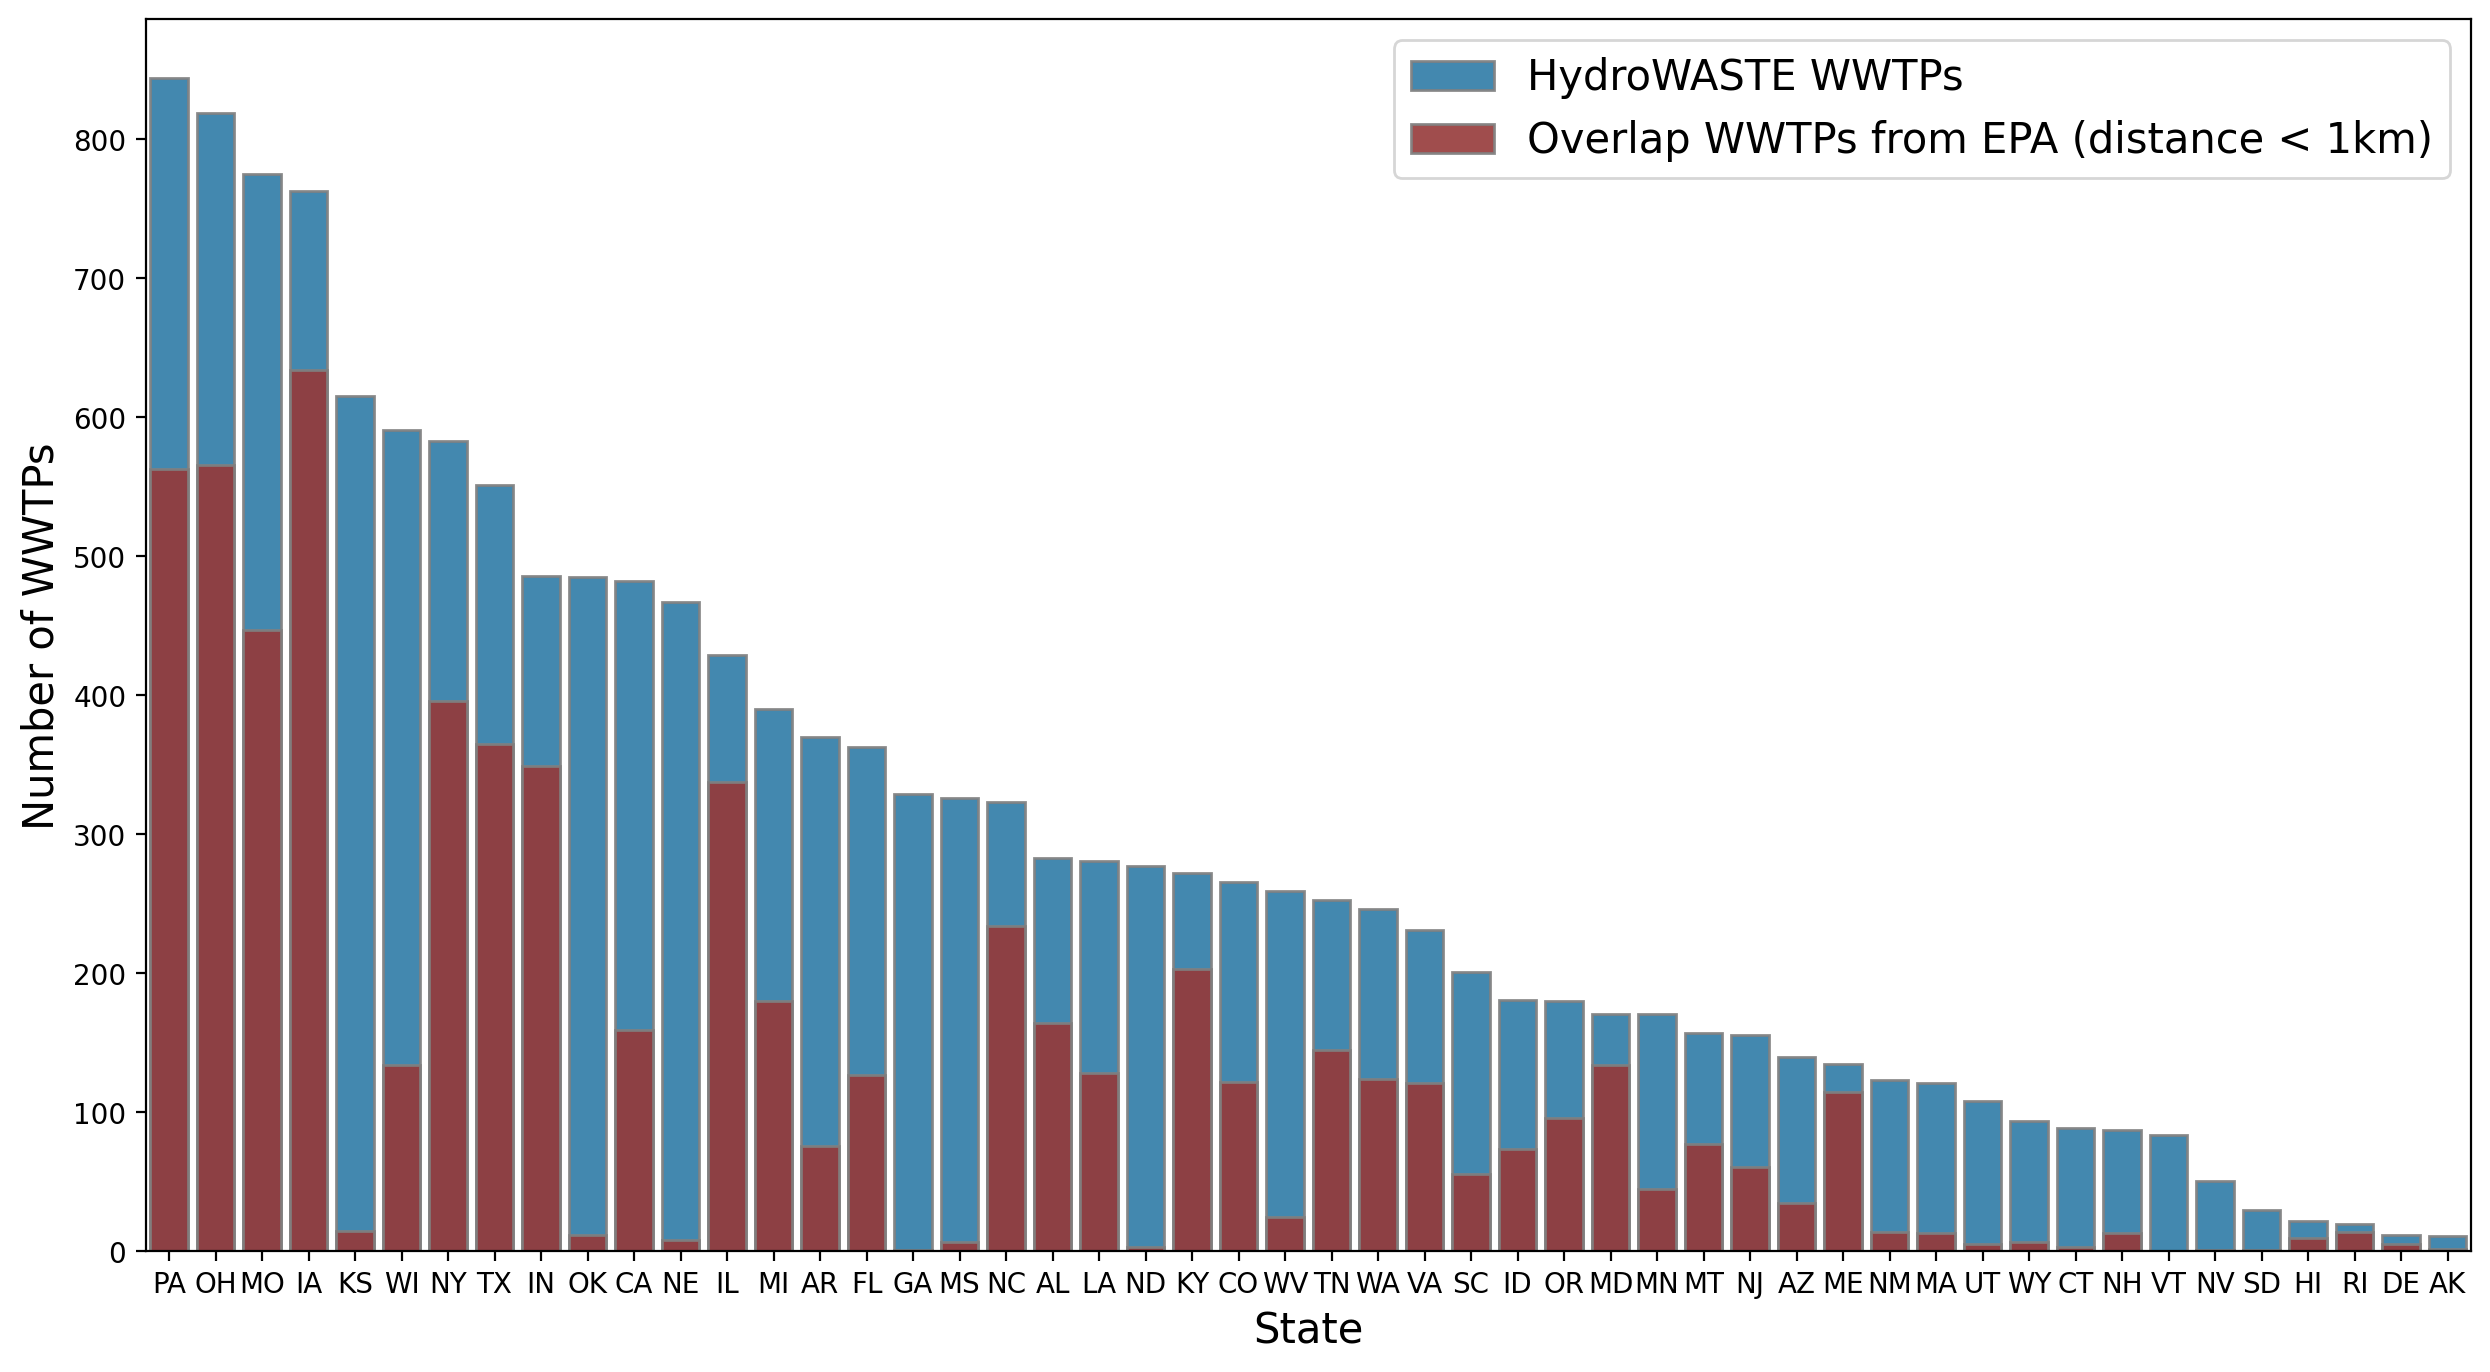

In [12]:
# plot the overlap between HydroWASTE and EPA
fig, ax = plt.subplots(figsize=(15, 8))
sorted_hw_epa_statewise_summary = hw_epa_statewise_summary.sort_values(
    by="num_HW_WWTPs", ascending=False
)
sns.barplot(
    x="state",
    y="num_HW_WWTPs",
    data=sorted_hw_epa_statewise_summary,
    color=blue_color,
    alpha=0.9,
    label="HydroWASTE WWTPs",
    edgecolor="grey",
)
sns.barplot(
    x="state",
    y="num_HW_WWTPs_within_1km",
    data=sorted_hw_epa_statewise_summary,
    color="brown",
    alpha=0.9,
    label="Overlap WWTPs from EPA (distance < 1km)",
    edgecolor="grey",
)
plt.xlabel("State", fontsize=15)
plt.ylabel("Number of WWTPs", fontsize=15)
plt.legend(fontsize=15)
plt.show()